In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.models import load_model

In [2]:
# train dataset
train_file = r'C:\Users\HP\Desktop\Data_Train_Ai_CapCha\trainDataset_captcha\data.txt'
read_txt = open(train_file, encoding="utf8")

train_data = [s.strip() for s in read_txt.readlines()]
# test_val dataset
test_file = r'C:\Users\HP\Desktop\Data_Train_Ai_CapCha\testDataset_captcha\data.txt'
read_txt = open(test_file, encoding="utf8")

test_data = [s.strip() for s in read_txt.readlines()]

In [3]:
def covert_label_to_array(captcha_label, char_):
    new_label = []
    for captcha in captcha_label:
        char_label = []
        for char in captcha:
            char_label.append(char_.index(char))
        new_label.append(char_label)
    return new_label

def decode_batch_predictions(pred, char_):
    max_length = 5
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = ''
    #conver to text
    for res in results:
        res = np.array(res)
        for r in res:
            try:
                output_text += char_[int(r)]
            except:
                output_text += '[UNK]'
    return output_text

In [42]:
# train data
url_dir = r'C:\Users\HP\Desktop\Data_Train_Ai_CapCha\trainDataset_captcha\\'
captcha_image = []
captcha_label = []
for captcha in train_data:
    img = np.array(Image.open(url_dir+captcha[:captcha.find(":")]+'.png').convert('L')).reshape(50, 145, 1)
    captcha_label.append(str(captcha[captcha.find(":")+1:]))
    captcha_image.append(img)
    
char_ = list(set(char for label in captcha_label for char in label))
print(char_)
captcha_label = covert_label_to_array(captcha_label, char_)

x_train, y_train = captcha_image, captcha_label

['u', '7', '9', 'a', 'U', 'y', 'R', 'n', 'H', 'b', '6', 's', 'm', 'C', '2', 'h', 'v', 'j', 'c', 'T', 'q', 'B', 'K', 'P', 'd', 'f', 'Q', 'g', 'r', 'X', 'G', '8', 'S', 't', 'V', '3', '4', 'x', 'z', 'F', '5', 'Z', 'p', 'e', 'k']


In [43]:
# test data
url_dir = r'C:\Users\HP\Desktop\Data_Train_Ai_CapCha\testDataset_captcha\\'
captcha_image = []
captcha_label = []
for captcha in test_data:
    img = np.array(Image.open(url_dir+captcha[:captcha.find(":")]+'.png').convert('L')).reshape(50, 145, 1)
    captcha_label.append(str(captcha[captcha.find(":")+1:]))
    captcha_image.append(img)

captcha_label = np.array(covert_label_to_array(captcha_label, char_))

from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(captcha_image, captcha_label, test_size = 0.5)

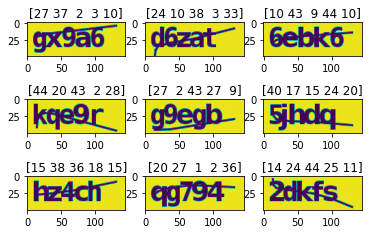

In [44]:
# vẽ một số dữ liệu
import matplotlib.pyplot as plt
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title(str(captcha_label[i]))
    plt.imshow(captcha_image[i])


In [45]:
x_train, x_test, y_train, y_test, x_val, y_val = np.array(x_train), np.array(x_test),  np.array(y_train), np.array(y_test), np.array(x_val), np.array(y_val)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_val.shape)
print(y_val.shape)

(79612, 50, 145, 1)
(79612, 5)
(1011, 50, 145, 1)
(1011, 5)
(1012, 50, 145, 1)
(1012, 5)


In [46]:
# chuyển dữ liệu x_train về khoảng 0 và 1

x_train, x_test, x_val = x_train/ 255.0, x_test/ 255.0, x_val/ 255.0

In [47]:
print(x_train.shape)
print(y_train.shape)

(79612, 50, 145, 1)
(79612, 5)


In [4]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    img_width = 145
    img_height = 50
    # Inputs to the model
    input_img = layers.Input(shape=(img_height, img_width, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(5,), dtype="float32")

    # First conv block
    x = layers.Conv2D(32,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv1",)(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(64,(3, 3),activation="relu",kernel_initializer="he_normal",padding="same",name="Conv2",)(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_height // 4), (img_width // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(char_) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

NameError: name 'layers' is not defined

In [50]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 50, 145, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 50, 145, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 25, 72, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 25, 72, 64)   18496       ['pool1[0][0]']       

In [51]:
def encode_single_sample(img, label):
    return {"image": img, "label": label}

batch_size = 20
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample).batch(batch_size))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = (val_dataset.map(encode_single_sample).batch(batch_size))

history = model.fit(train_dataset, epochs=25, validation_data=(val_dataset))

Epoch 1/25
3981/3981 [==============================] - 456s 112ms/step - loss: 12.1212 - val_loss: 7.9036
Epoch 2/25
3981/3981 [==============================] - 407s 102ms/step - loss: 4.3366 - val_loss: 3.8492
Epoch 3/25
3981/3981 [==============================] - 400s 100ms/step - loss: 2.4491 - val_loss: 2.5230
Epoch 4/25
3981/3981 [==============================] - 393s 99ms/step - loss: 1.7993 - val_loss: 2.0092
Epoch 5/25
3981/3981 [==============================] - 401s 101ms/step - loss: 1.4452 - val_loss: 1.5838
Epoch 6/25
3981/3981 [==============================] - 398s 100ms/step - loss: 1.2354 - val_loss: 1.2678
Epoch 7/25
3981/3981 [==============================] - 406s 102ms/step - loss: 1.0992 - val_loss: 1.0709
Epoch 8/25
3981/3981 [==============================] - 401s 101ms/step - loss: 1.0088 - val_loss: 0.9387
Epoch 9/25
3981/3981 [==============================] - 414s 104ms/step - loss: 0.9299 - val_loss: 0.9659
Epoch 10/25
3981/3981 [=======================

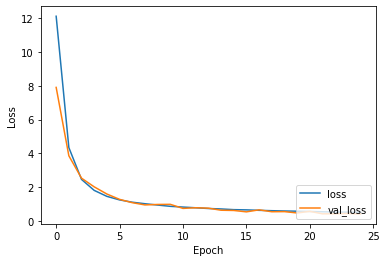

In [52]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [53]:
# save model
model.save('model_SolveCaptcha.h5')

In [54]:
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
prediction_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 50, 145, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 50, 145, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 25, 72, 32)        0         
                                                                 
 Conv2 (Conv2D)              (None, 25, 72, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 12, 36, 64)        0         
                                                                 
 reshape (Reshape)           (None, 12, 2304)          0         
                                                                 
 dense1 (Dense)              (None, 12, 64)            147

In [62]:
# save model
model.save('model_PredictCaptcha.h5')

1/1 [==============================] - 0s 19ms/step


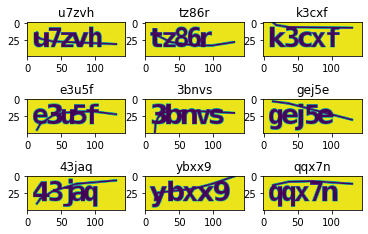

In [56]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = x_test[i]
    
    
    img = np.array(img)
    plt.imshow(img)
    img = img.reshape(50, 145, 1) 
    
    new_img = tf.expand_dims(img,0)
    new_img = new_img / 255
    preds = prediction_model.predict(new_img)
    pred_texts = decode_batch_predictions(preds, char_)
    
    plt.title(pred_texts)
    

(50, 145)
1/1 [==============================] - 4s 4s/step


RuntimeError: input: Attempting to capture an EagerTensor without building a function.

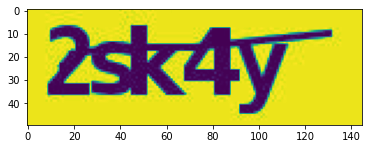

In [12]:
char_ =['u', '7', '9', 'a', 'U', 'y', 'R', 'n', 'H', 'b', '6', 's', 'm', 'C', '2', 'h', 'v', 'j', 'c', 'T', 'q', 'B', 'K', 'P', 'd', 'f', 'Q', 'g', 'r', 'X', 'G', '8', 'S', 't', 'V', '3', '4', 'x', 'z', 'F', '5', 'Z', 'p', 'e', 'k']

prediction_model = load_model('model_PredictCaptcha.h5')
img = Image.open(r'C:\Users\HP\Desktop\newthing AI\Solve_captcha\testDataset_captcha\00ad0655-a3df-44a1-8e0c-bb2b982c031e.png').convert('L')
img = img.resize((145, 50))
img = np.array(img)
plt.imshow(img)
print(img.shape)
img = img.reshape(50, 145, 1)
new_img = tf.expand_dims(img,0)
new_img = new_img / 255
preds = prediction_model.predict(new_img)
pred_texts = decode_batch_predictions(preds, char_)
import tensorflow.compat.v1 as tf1
with tf1.Session() as sess:
    y_pred = sess.run(tf1.argmax(new_img, 1), feed_dict={X: train_x, y: train_y})
    plt.title(pred_y)